In [ ]:
import pandas as pd
from pathlib import Path    
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
BASE = Path("../data/processed")
X_tr = pd.read_csv(BASE / "X_train.csv", index_col=0,parse_dates=True)
Y_tr = pd.read_csv(BASE / "y_train2.csv", index_col=0,parse_dates=True)

In [ ]:
holed_cols = [c for c in X_tr.columns if c.startswith("holed_")]
clean_cols = [c for c in X_tr.columns if c not in holed_cols]

In [ ]:
def make_XY_val(df: pd.DataFrame, Y: pd.DataFrame, holed_cols: list, n_lags: int = 5, n_leads: int = 5):
    """
    Crée X_val et Y_val enrichis pour imputation temporelle :
        - lags / leads configurables
        - stats globales (range, std_rel)
        - stats locales (moyenne/écart-type autour du trou)
        - encodage temporel (hour_sin/cos)
        - profil horaire moyen
    """
    all_rows = []
    y_val_rows = []

    df_feat_time = pd.DataFrame({
        'weekday': df.index.weekday,
        'hour': df.index.hour,
        'minute': df.index.minute
    }, index=df.index)

    # Stats globales par colonne
    df_stats = df.describe().T[['mean', 'std', 'min', 'max']]
    df_stats['range'] = df_stats['max'] - df_stats['min']
    df_stats['std_rel'] = df_stats['std'] / df_stats['mean']

    # Profil horaire moyen
    profiles = df.groupby([df.index.weekday, df.index.hour]).mean()

    for col in tqdm(holed_cols, desc="Création de X_val enrichi"):
        series = df[col]
        missing_idx = series[series.isna()].index
        col_mean = series.mean(skipna=True)
        col_std = series.std(skipna=True)

        for idx in missing_idx:
            i = df.index.get_loc(idx)
            hour_val = df_feat_time.at[idx, 'hour'] + df_feat_time.at[idx, 'minute'] / 60.0

            row = {
                'col': col,
                'timestamp': idx,
                'mean': col_mean,
                'std': col_std,
                'range': df_stats.loc[col, 'range'],
                'std_rel': df_stats.loc[col, 'std_rel'],
                'weekday': df_feat_time.at[idx, 'weekday'],
                'hour': hour_val,
                'hour_sin': np.sin(2 * np.pi * hour_val / 24),
                'hour_cos': np.cos(2 * np.pi * hour_val / 24),
                'profile_hour_mean': profiles.at[(df_feat_time.at[idx, 'weekday'], df_feat_time.at[idx, 'hour']), col],
            }

            # lags/leads
            for l in range(1, n_lags + 1):
                row[f'lag_{l}'] = series.iloc[i - l] if i - l >= 0 else np.nan
            for l in range(1, n_leads + 1):
                row[f'lead_{l}'] = series.iloc[i + l] if i + l < len(series) else np.nan

            # local window stats
            window_vals = series[max(0, i-6):min(len(series), i+6)].dropna()
            row['local_mean'] = window_vals.mean() if len(window_vals) else col_mean
            row['local_std'] = window_vals.std() if len(window_vals) else col_std

            # target
            y_val_rows.append({'timestamp': idx, 'col': col, 'y_true': Y.loc[idx, col]})
            all_rows.append(row)

    X_val = pd.DataFrame(all_rows).set_index('timestamp')
    Y_val = pd.DataFrame(y_val_rows).set_index('timestamp')
    print(f"✅ X_val : {len(X_val):,} lignes | {X_val.shape[1]} features")
    return X_val, Y_val


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def make_train_fast(df, clean_cols, n_samples=20000, n_lags=5, n_leads=5, random_state=42):
    """
    Crée un dataset d'entraînement enrichi, aligné avec make_XY_val :
        - tirage aléatoire de n_samples points parmi les colonnes propres
        - features : mean, std, range, std_rel, weekday, hour, hour_sin/cos
        - profil horaire moyen
        - lags, leads, local_mean/local_std
        - y (valeur vraie)
    """

    np.random.seed(random_state)
    all_rows = []

    # ✅ Pré-calcul des features globales
    df_feat_time = pd.DataFrame({
        "weekday": df.index.weekday,
        "hour": df.index.hour,
        "minute": df.index.minute
    }, index=df.index)

    # Stats globales par colonne
    df_stats = df.describe().T[["mean", "std", "min", "max"]]
    df_stats["range"] = df_stats["max"] - df_stats["min"]
    df_stats["std_rel"] = df_stats["std"] / df_stats["mean"]

    # Profil horaire moyen
    profiles = df.groupby([df.index.weekday, df.index.hour]).mean()

    # ✅ Liste des positions valides
    print(" Préparation des positions valides...")
    valid_positions = []
    for col in tqdm(clean_cols, desc="Scan des colonnes propres"):
        notna_idx = np.where(~df[col].isna())[0]
        for i in notna_idx:
            valid_positions.append((col, i))
    total_positions = len(valid_positions)
    print(f"\n {total_positions:,} valeurs disponibles pour tirage aléatoire.")
    n_samples = min(n_samples, total_positions)

    # ✅ Tirage aléatoire
    sampled_idx = np.random.choice(total_positions, size=n_samples, replace=False)
    sampled_positions = np.array(valid_positions, dtype=object)[sampled_idx]

    print("\n Construction du dataset d'entraînement enrichi...")
    for col, i in tqdm(sampled_positions, desc="Création des lignes", total=n_samples):
        ts = df.index[i]
        series = df[col]

        hour_val = ts.hour + ts.minute / 60.0

        row = {
            "col": col,
            "timestamp": ts,
            "weekday": ts.weekday(),
            "hour": hour_val,
            "hour_sin": np.sin(2 * np.pi * hour_val / 24),
            "hour_cos": np.cos(2 * np.pi * hour_val / 24),
            "mean": series.mean(skipna=True),
            "std": series.std(skipna=True),
            "range": df_stats.loc[col, "range"],
            "std_rel": df_stats.loc[col, "std_rel"],
            "profile_hour_mean": profiles.at[(ts.weekday(), ts.hour), col],
            "y": series.iat[i],
        }

        # Lags
        for l in range(1, n_lags + 1):
            row[f"lag_{l}"] = series.iat[i - l] if i - l >= 0 else np.nan

        # Leads
        for l in range(1, n_leads + 1):
            row[f"lead_{l}"] = series.iat[i + l] if i + l < len(series) else np.nan

        # Stats locales (fenêtre ±6 points)
        window_vals = series[max(0, i - 6):min(len(series), i + 6)].dropna()
        row["local_mean"] = window_vals.mean() if len(window_vals) else row["mean"]
        row["local_std"] = window_vals.std() if len(window_vals) else row["std"]

        all_rows.append(row)

    # ✅ Construction finale
    X_train = pd.DataFrame(all_rows)
    X_train.set_index("timestamp", inplace=True)

    print(f"\n✅ Jeu d'entraînement enrichi créé : {len(X_train):,} lignes × {X_train.shape[1]} colonnes")
    return X_train


In [ ]:
def check_train_distribution(X_train):
    """
    Affiche quelques vérifications de distribution pour le jeu d'entraînement.
    Vérifie la répartition par heure, jour de la semaine et valeurs cibles.
    """
    print("\n🔎 Vérification de la distribution de l'échantillon...")
    print(f"Nombre total de points : {len(X_train):,}")

    # 1️⃣ Répartition par jour de la semaine
    weekday_counts = X_train['weekday'].value_counts().sort_index()
    print("\n📅 Répartition par jour de la semaine :")
    print(weekday_counts.to_string())

    # 2️⃣ Répartition par heure de la journée
    hour_counts = X_train['hour'].value_counts().sort_index()
    print("\n🕐 Répartition par heure :")
    print(hour_counts.to_string())

    # 3️⃣ Stats globales sur la cible y
    print("\n⚡ Statistiques sur la consommation (y) :")
    print(X_train['y'].describe(percentiles=[.05, .25, .5, .75, .95]).to_string())

    # 4️⃣ Visualisations
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    sns.countplot(x='weekday', data=X_train, ax=axes[0], palette='Blues')
    axes[0].set_title("Distribution par jour de la semaine")
    axes[0].set_xlabel("Jour (0 = lundi)")
    axes[0].set_ylabel("Nb. d'échantillons")

    sns.countplot(x='hour', data=X_train, ax=axes[1], palette='Greens')
    axes[1].set_title("Distribution par heure de la journée")
    axes[1].set_xlabel("Heure")
    axes[1].set_ylabel("Nb. d'échantillons")

    sns.histplot(X_train['y'], bins=30, ax=axes[2], color='purple', kde=True)
    axes[2].set_title("Distribution des valeurs de consommation")
    axes[2].set_xlabel("Valeur (y)")
    axes[2].set_ylabel("Densité")

    plt.tight_layout()
    plt.show()


In [ ]:
X_val, Y_val = make_XY_val(X_tr, Y_tr, holed_cols)

Création de X_val: 100%|██████████| 999/999 [00:07<00:00, 130.10it/s]


In [ ]:
X_train = make_train_fast(df=X_tr, clean_cols=clean_cols, n_samples=20000)

 Préparation des positions valides...


Scan des colonnes propres: 100%|██████████| 18784/18784 [00:03<00:00, 5377.15it/s]



 19,854,688 valeurs disponibles pour tirage aléatoire.

 Construction du dataset d'entraînement...


Création des lignes: 100%|██████████| 20000/20000 [00:07<00:00, 2634.46it/s]



✅ Jeu d'entraînement créé : 20,000 lignes × 17 colonnes



🔎 Vérification de la distribution de l'échantillon...
Nombre total de points : 20,000

📅 Répartition par jour de la semaine :
weekday
0    3664
1    2713
2    2708
3    2718
4    2760
5    2721
6    2716

🕐 Répartition par heure :
hour
0.0     456
0.5     383
1.0     398
1.5     399
2.0     428
2.5     421
3.0     399
3.5     455
4.0     425
4.5     405
5.0     429
5.5     410
6.0     435
6.5     392
7.0     409
7.5     430
8.0     415
8.5     420
9.0     450
9.5     414
10.0    425
10.5    410
11.0    439
11.5    416
12.0    413
12.5    397
13.0    410
13.5    411
14.0    409
14.5    414
15.0    400
15.5    436
16.0    400
16.5    431
17.0    434
17.5    437
18.0    417
18.5    368
19.0    437
19.5    416
20.0    397
20.5    398
21.0    398
21.5    420
22.0    426
22.5    417
23.0    430
23.5    421

⚡ Statistiques sur la consommation (y) :
count    20000.000000
mean       367.262500
std        439.420665
min          0.000000
5%          14.000000
25%         74.000000
50%        20

C:\Users\marqu\AppData\Local\Temp\ipykernel_21384\1988078593.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='weekday', data=X_train, ax=axes[0], palette='Blues')
C:\Users\marqu\AppData\Local\Temp\ipykernel_21384\1988078593.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hour', data=X_train, ax=axes[1], palette='Greens')


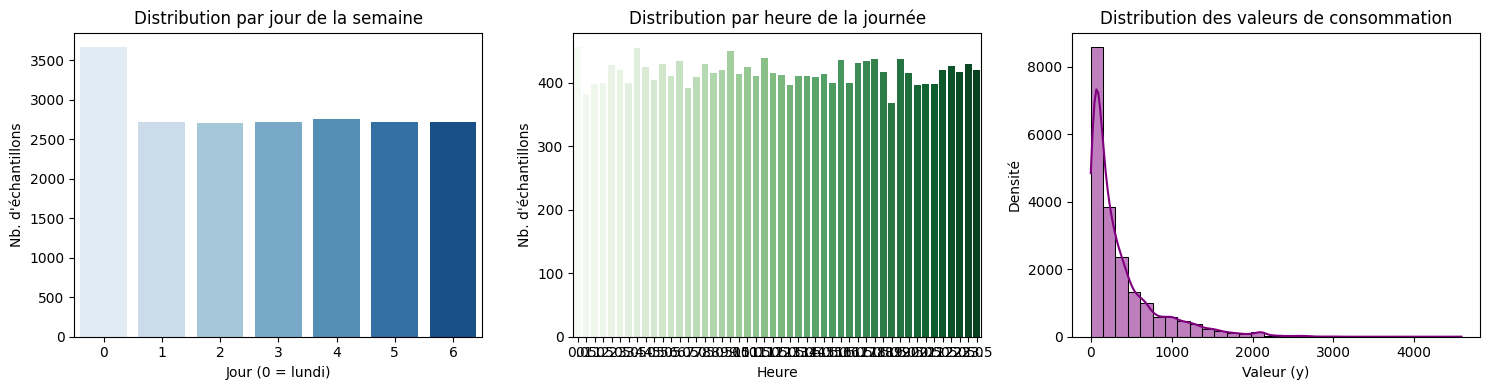

In [ ]:
check_train_distribution(X_train)

In [ ]:
def save_preprocessed_datasets(X_train, X_val,Y_val, output_dir="../data/preprocessed"):
    """
    Sauvegarde les datasets prétraités (train & val) dans le dossier choisi.
    Crée le dossier s'il n'existe pas.
    """
    os.makedirs(output_dir, exist_ok=True)

    train_path = os.path.join(output_dir, "X_train_features.csv")
    val_path = os.path.join(output_dir, "X_val_features.csv")
    yval_path = os.path.join(output_dir, "Y_val_true.csv")

    print(f"Sauvegarde des fichiers dans : {output_dir}")
    X_train.to_csv(train_path, index=False)
    X_val.to_csv(val_path, index=False)
    Y_val.to_csv(yval_path, index=False)

    return train_path, val_path, yval_path


In [ ]:
save_preprocessed_datasets(X_train,X_val,Y_val)

Sauvegarde des fichiers dans : ../data/preprocessed


('../data/preprocessed\\X_train_features.csv',
 '../data/preprocessed\\X_val_features.csv',
 '../data/preprocessed\\Y_val_true.csv')